[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Reddit Data Size: 13525
Therapy Data Size: 555
Top 10 Reddit Symptoms: [('pain', 1865), ('headache', 362), ('cough', 264), ('fever', 237), ('fatigue', 173), ('nausea', 151), ('rash', 122), ('swelling', 102), ('diarrhea', 95), ('dizziness', 83)]
Top 10 Reddit Treatments: [('medication', 838), ('sleep', 616), ('exercise', 293), ('diet', 199), ('therapy', 67), ('yoga', 18), ('fitness', 17), ('meditation', 12), ('hydration', 5), ('cbt', 3)]
Top 10 Reddit Diseases: [('anxiety', 532), ('allergy', 243), ('cold', 201), ('stress', 200), ('depression', 185), ('cancer', 141), ('migraine', 134), ('asthma', 117), ('adhd', 77), ('flu', 59)]
Top 10 Therapy Symptoms: [('pain', 31), ('fatigue', 5), ('headache', 5), ('numbness', 3), ('bleeding', 3), ('cough', 2), ('vomiting', 2), ('nausea', 2), ('dizziness', 1)]
Top 10 Therapy Treatments: [('diet', 53), ('exercise', 51), ('medication', 35), ('sleep', 32), ('therapy', 26), ('counseling', 23), ('meditation', 16), ('mindfulness', 14), ('yoga', 14), ('nutri

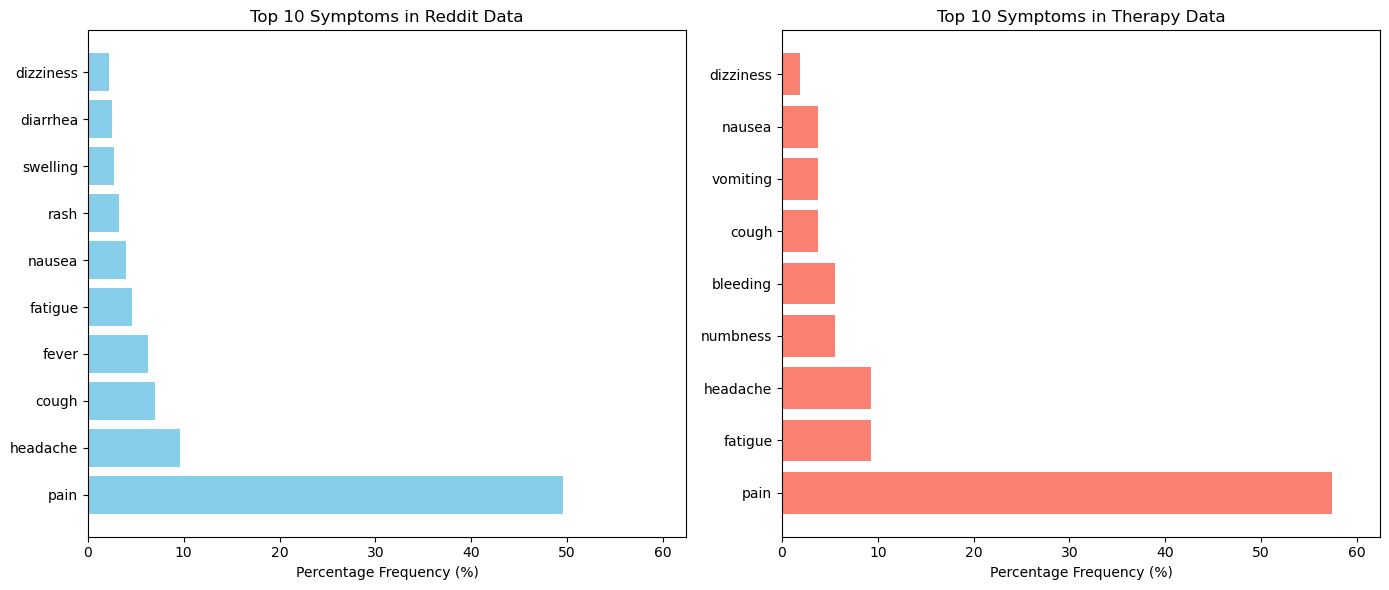

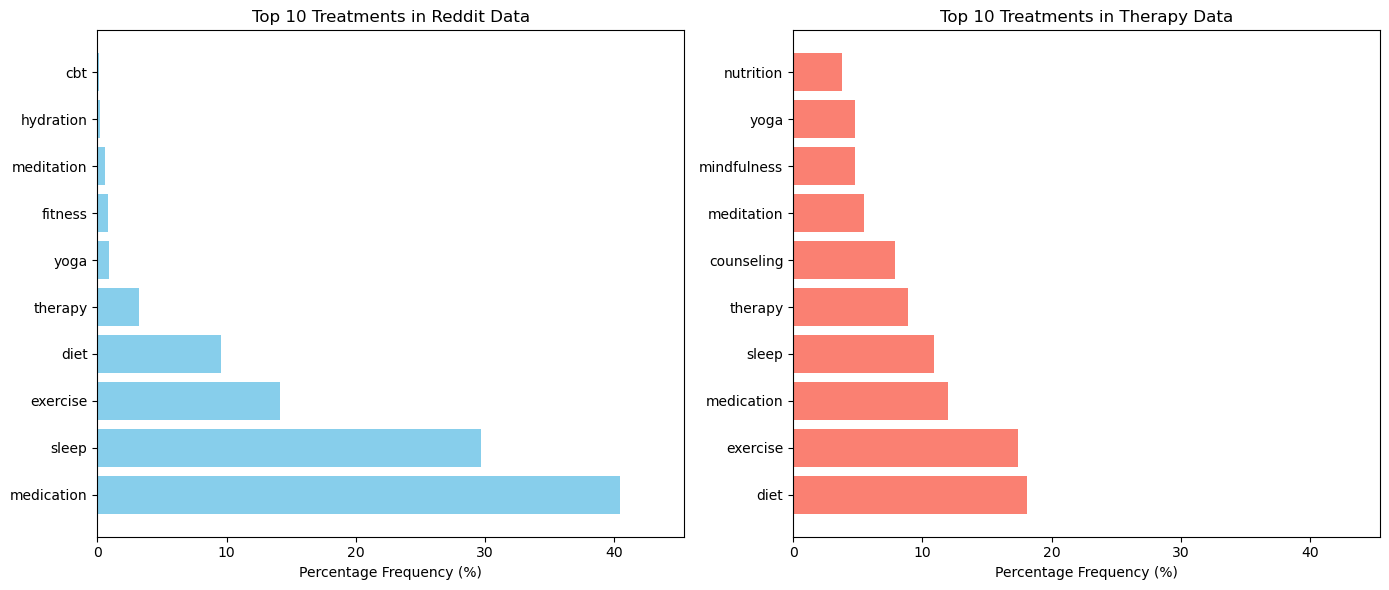

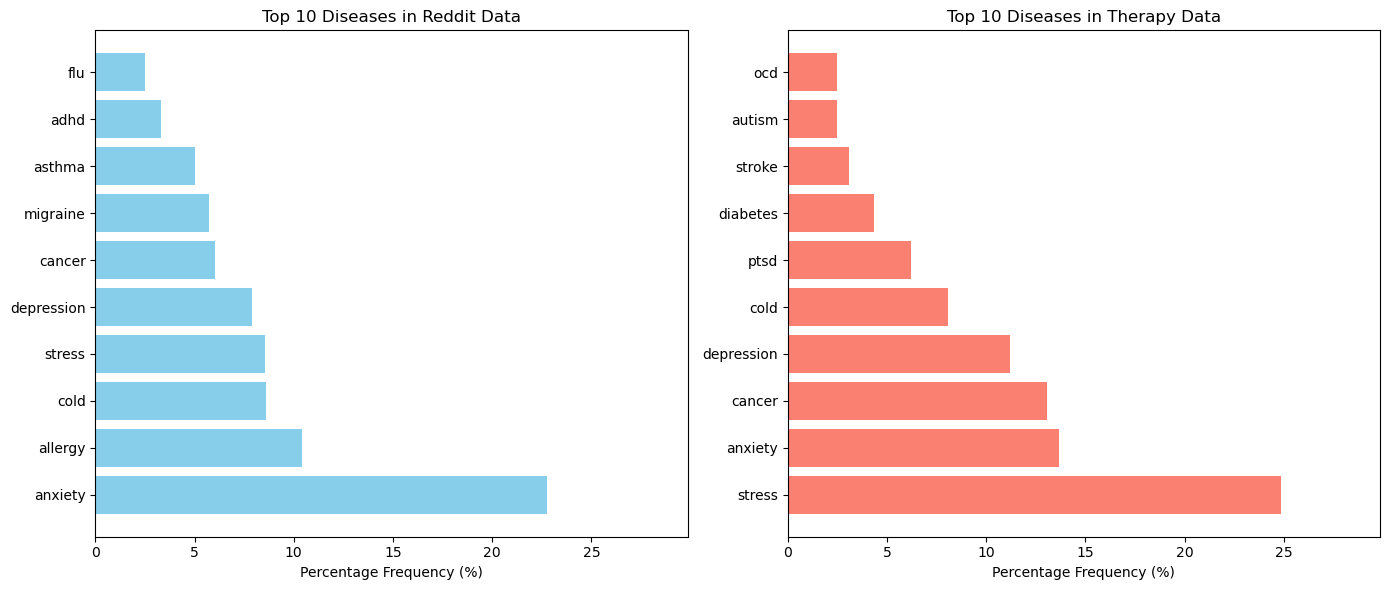

Reddit Sentiment Analysis: {'pos': 3402, 'neu': 4608, 'neg': 5515}
Therapy Sentiment Analysis: {'pos': 255, 'neu': 195, 'neg': 105}


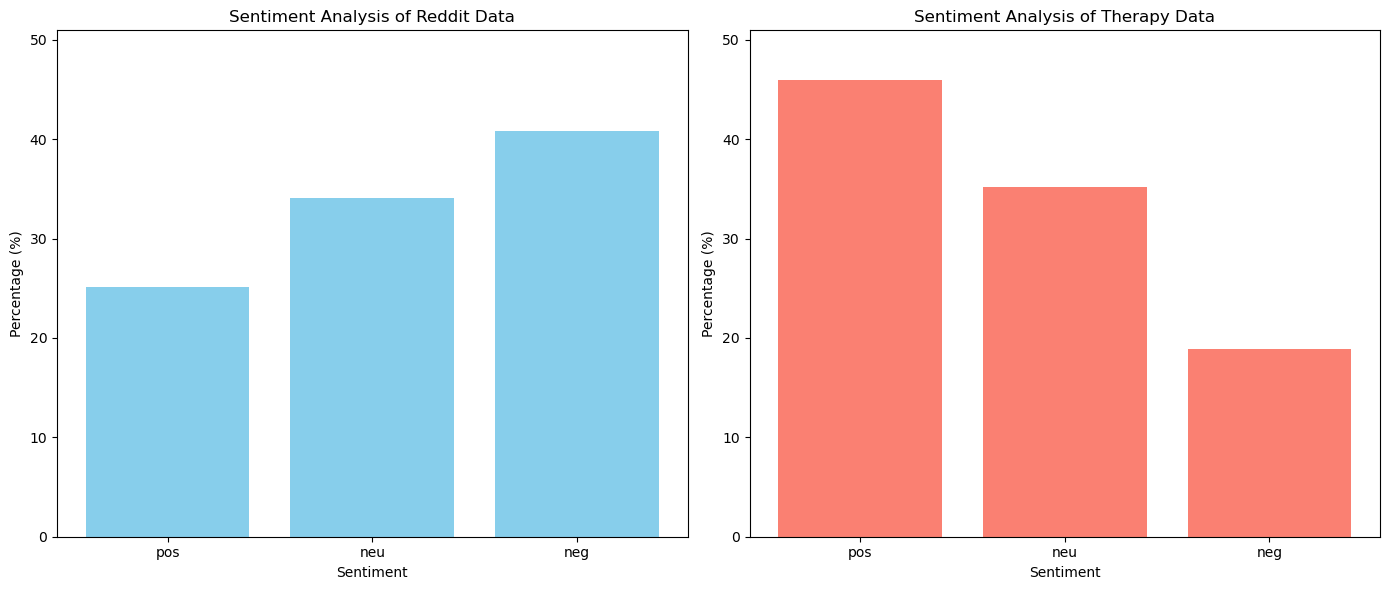

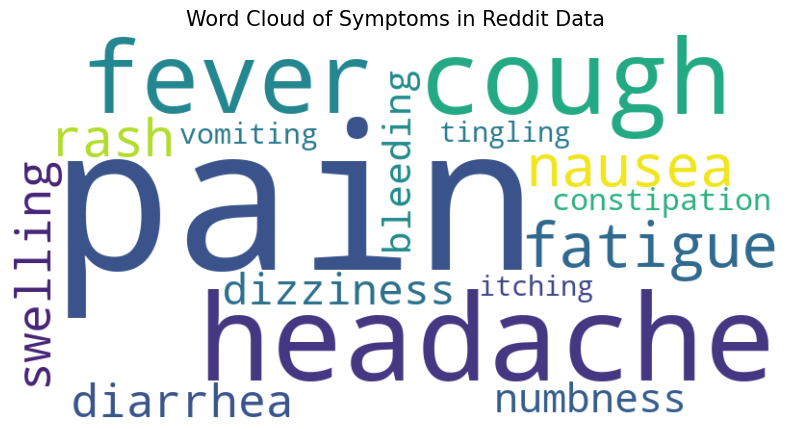

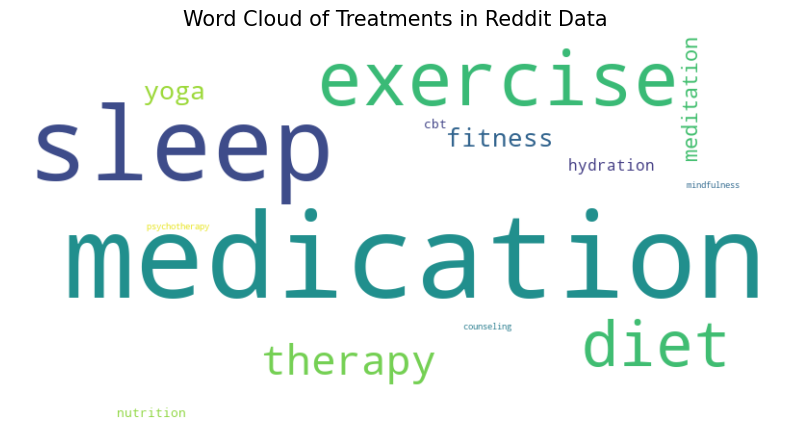

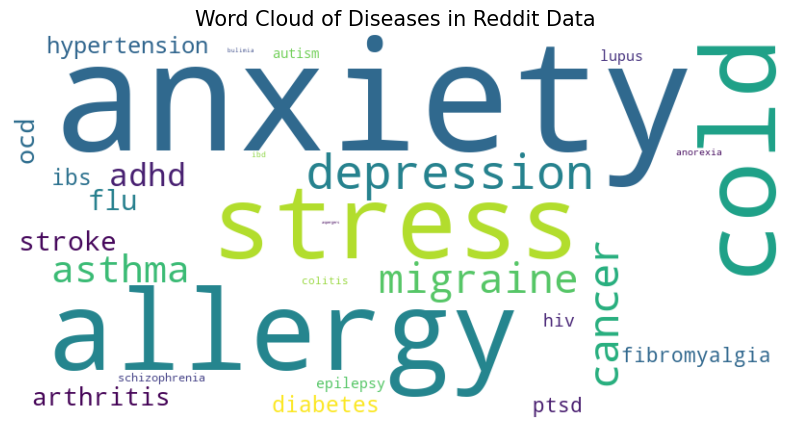

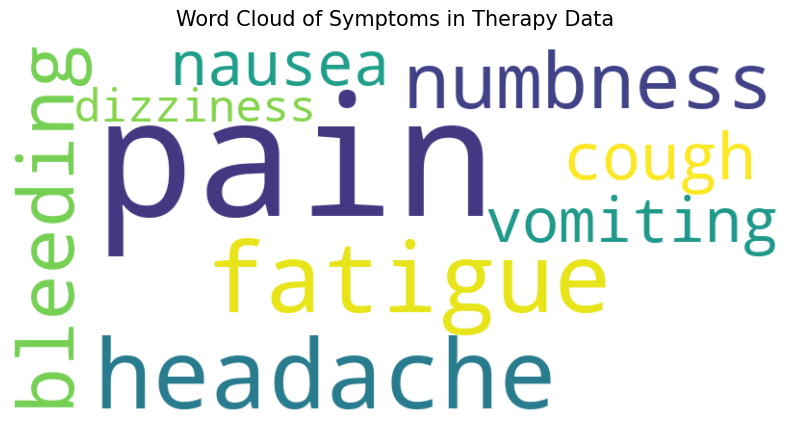

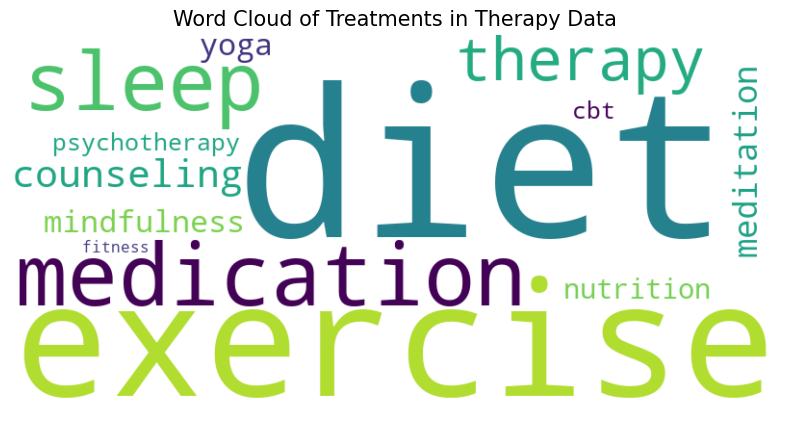

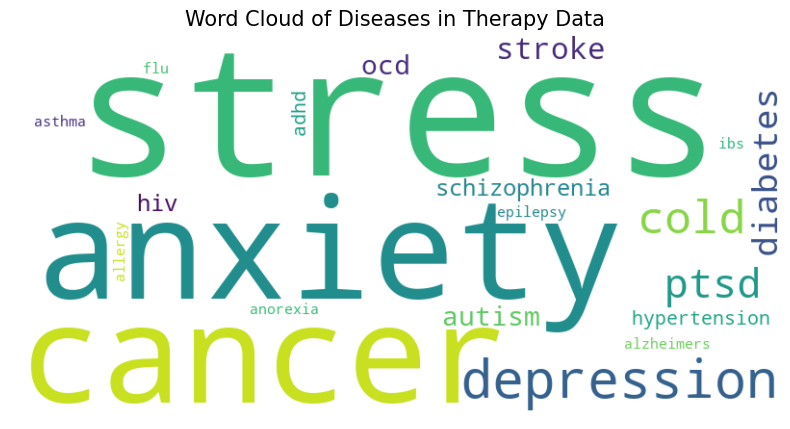

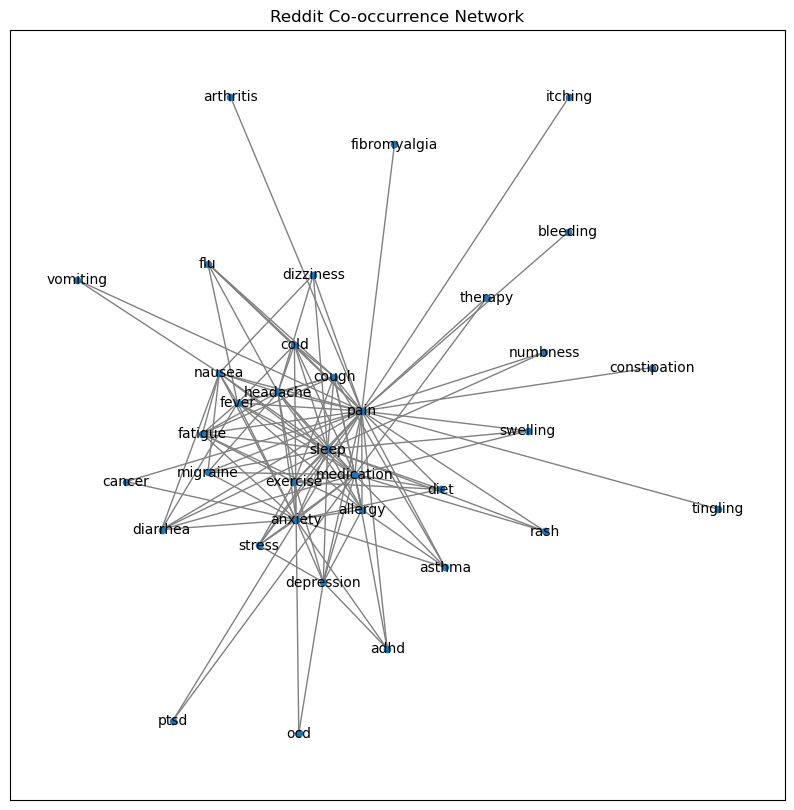

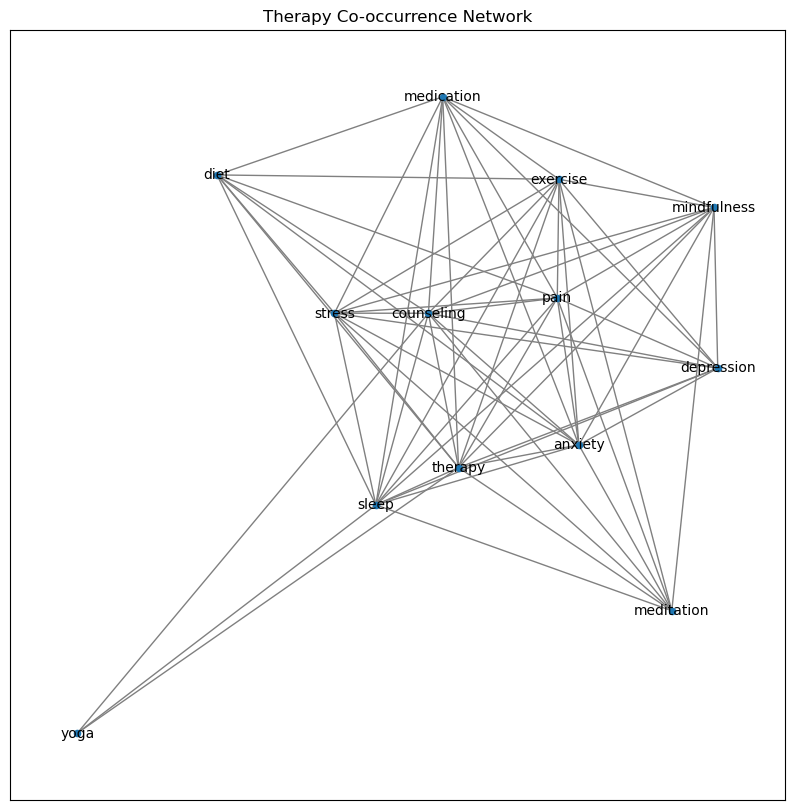

Reddit Data - Word Similarities:
Similar words to 'pain': [('sharp', 0.9750116467475891), ('ache', 0.9714873433113098), ('stabbing', 0.9680752754211426), ('dull', 0.9671491384506226), ('cramp', 0.9662943482398987), ('discomfort', 0.9638466835021973), ('slight', 0.9596922993659973), ('stinging', 0.9574404954910278), ('excruciate', 0.9559781551361084), ('shoulder', 0.9550254344940186)]

Similar words to 'therapy': [('unfortunately', 0.9954466819763184), ('suppose', 0.9951682686805725), ('respond', 0.9944583177566528), ('effect', 0.9944361448287964), ('convince', 0.9939095377922058), ('admit', 0.9924460053443909), ('crisis', 0.9919514656066895), ('tuesday', 0.9919464588165283), ('new', 0.9919360876083374), ('lockdown', 0.9919119477272034)]

Similar words to 'cancer': [('unlikely', 0.985362708568573), ('radiologist', 0.9836559295654297), ('request', 0.9825637340545654), ('imaging', 0.9796862602233887), ('endocrinologist', 0.9790199995040894), ('cystoscopy', 0.9788774251937866), ('benign', 

In [6]:
import os
import glob
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import spacy
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import gensim
from gensim.models import Word2Vec, LdaModel
from gensim import corpora
import networkx as nx
from itertools import combinations

# Initialize spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Download NLTK resources
nltk.download('vader_lexicon')

# Paths to Reddit and Therapy datasets
reddit_dir_path = r'C:\Users\dhruv\Documents\dataset\reddit'
therapy_dir_path = r'C:\Users\dhruv\Documents\dataset\therapy'

def load_data_from_directory(dir_path, encoding='utf-8'):
    data = []
    for file_path in glob.glob(os.path.join(dir_path, '*.txt')):
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                data.extend(file.read().split('""'))
        except UnicodeDecodeError:
            print(f"Error decoding file: {file_path}. Trying a different encoding.")
    return data

# Load datasets
reddit_data = load_data_from_directory(reddit_dir_path)
therapy_data = load_data_from_directory(therapy_dir_path)

print(f"Reddit Data Size: {len(reddit_data)}")
print(f"Therapy Data Size: {len(therapy_data)}")

# Define the updated list of trigger words
trigger_words = {
    "symptoms": [
        "pain", "fatigue", "headache", "fever", "cough", "sore throat",
        "nausea", "vomiting", "diarrhea", "constipation", "dizziness",
        "shortness of breath", "chest pain", "back pain", "stomach ache",
        "joint pain", "muscle pain", "swelling", "rash", "itching", "bleeding",
        "numbness", "tingling"
    ],
    "treatments": [
        "medication", "therapy", "antibiotics", "painkillers", "analgesics",
        "antidepressants", "cbt", "psychotherapy", "counseling", "support groups",
        "self care", "holistic health", "alternative medicine", "natural remedies",
        "herbal medicine", "diet", "nutrition", "exercise", "fitness", "sleep",
        "hydration", "mindfulness", "meditation", "yoga", "stress relief"
    ],
    "diseases": [
        "covid 19", "flu", "cold", "asthma", "diabetes", "hypertension",
        "heart disease", "cancer", "stroke", "arthritis", "epilepsy", "migraine",
        "allergy", "allergies", "autoimmune disease", "multiple sclerosis",
        "parkinsons disease", "alzheimers", "lupus", "chronic fatigue",
        "fibromyalgia", "ibs", "ibd", "crohns disease", "colitis", "hiv", "aids",
        "lyme disease", "mental health", "depression", "anxiety", "stress",
        "panic attacks", "bipolar disorder", "schizophrenia", "ocd", "ptsd",
        "adhd", "autism", "aspergers", "eating disorders", "anorexia", "bulimia",
        "self harm", "suicidal thoughts"
    ]
}

# Function to clean, preprocess, and lemmatize the text data
def preprocess_text(text):
    doc = nlp(text.lower())
    lemmatized_text = ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and len(token) > 2])
    lemmatized_text = re.sub(r'\s+', ' ', lemmatized_text)
    lemmatized_text = re.sub(r'[^\w\s]', '', lemmatized_text)
    return lemmatized_text

# Preprocess the datasets
reddit_data = [preprocess_text(entry) for entry in reddit_data if entry]
therapy_data = [preprocess_text(entry) for entry in therapy_data if entry]

# Function to label entities based on custom matching
def label_custom_entities(texts, trigger_words):
    entities = []
    for text in texts:
        words = set(text.split())
        for word in words:
            if word in trigger_words["symptoms"]:
                entities.append((word, 'SYMPTOM'))
            elif word in trigger_words["treatments"]:
                entities.append((word, 'TREATMENT'))
            elif word in trigger_words["diseases"]:
                entities.append((word, 'DISEASE'))
    return entities

# Extract entities from both datasets
reddit_entities = label_custom_entities(reddit_data, trigger_words)
therapy_entities = label_custom_entities(therapy_data, trigger_words)

# Separate entities by type
reddit_symptoms = [entity[0] for entity in reddit_entities if entity[1] == 'SYMPTOM']
reddit_treatments = [entity[0] for entity in reddit_entities if entity[1] == 'TREATMENT']
reddit_diseases = [entity[0] for entity in reddit_entities if entity[1] == 'DISEASE']

therapy_symptoms = [entity[0] for entity in therapy_entities if entity[1] == 'SYMPTOM']
therapy_treatments = [entity[0] for entity in therapy_entities if entity[1] == 'TREATMENT']
therapy_diseases = [entity[0] for entity in therapy_entities if entity[1] == 'DISEASE']

# Calculate percentage frequencies for comparison
def calculate_percentage_frequencies(freq_dict, total):
    if total == 0:
        return {}
    return {key: (value / total) * 100 for key, value in freq_dict.items()}

# Count and calculate percentage frequencies of entities
reddit_symptom_freq = calculate_percentage_frequencies(Counter(reddit_symptoms), len(reddit_symptoms))
reddit_treatment_freq = calculate_percentage_frequencies(Counter(reddit_treatments), len(reddit_treatments))
reddit_disease_freq = calculate_percentage_frequencies(Counter(reddit_diseases), len(reddit_diseases))

therapy_symptom_freq = calculate_percentage_frequencies(Counter(therapy_symptoms), len(therapy_symptoms))
therapy_treatment_freq = calculate_percentage_frequencies(Counter(therapy_treatments), len(therapy_treatments))
therapy_disease_freq = calculate_percentage_frequencies(Counter(therapy_diseases), len(therapy_diseases))

print("Top 10 Reddit Symptoms:", Counter(reddit_symptoms).most_common(10))
print("Top 10 Reddit Treatments:", Counter(reddit_treatments).most_common(10))
print("Top 10 Reddit Diseases:", Counter(reddit_diseases).most_common(10))

print("Top 10 Therapy Symptoms:", Counter(therapy_symptoms).most_common(10))
print("Top 10 Therapy Treatments:", Counter(therapy_treatments).most_common(10))
print("Top 10 Therapy Diseases:", Counter(therapy_diseases).most_common(10))

# Visualization: Entity Frequency Comparison with Same Scale as Percentage
def plot_entity_frequency(entity_freq1, entity_freq2, title1, title2):
    if not entity_freq1 or not entity_freq2:
        print(f"Cannot plot {title1} and {title2} due to empty data.")
        return

    df1 = pd.DataFrame(entity_freq1.items(), columns=['Entity', 'Frequency']).sort_values(by='Frequency', ascending=False).head(10)
    df2 = pd.DataFrame(entity_freq2.items(), columns=['Entity', 'Frequency']).sort_values(by='Frequency', ascending=False).head(10)

    max_freq = max(df1['Frequency'].max(), df2['Frequency'].max())

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.barh(df1['Entity'], df1['Frequency'], color='skyblue')
    plt.xlim(0, max_freq + 5)
    plt.xlabel('Percentage Frequency (%)')
    plt.title(title1)

    plt.subplot(1, 2, 2)
    plt.barh(df2['Entity'], df2['Frequency'], color='salmon')
    plt.xlim(0, max_freq + 5)
    plt.xlabel('Percentage Frequency (%)')
    plt.title(title2)

    plt.tight_layout()
    plt.show()

# Plotting results for Symptoms, Treatments, and Diseases as percentages
plot_entity_frequency(reddit_symptom_freq, therapy_symptom_freq, 'Top 10 Symptoms in Reddit Data', 'Top 10 Symptoms in Therapy Data')
plot_entity_frequency(reddit_treatment_freq, therapy_treatment_freq, 'Top 10 Treatments in Reddit Data', 'Top 10 Treatments in Therapy Data')
plot_entity_frequency(reddit_disease_freq, therapy_disease_freq, 'Top 10 Diseases in Reddit Data', 'Top 10 Diseases in Therapy Data')

# Function to perform sentiment analysis
def analyze_sentiment(texts):
    sid = SentimentIntensityAnalyzer()
    sentiments = {'pos': 0, 'neu': 0, 'neg': 0}
    for text in texts:
        scores = sid.polarity_scores(text)
        if scores['compound'] >= 0.05:
            sentiments['pos'] += 1
        elif scores['compound'] <= -0.05:
            sentiments['neg'] += 1
        else:
            sentiments['neu'] += 1
    return sentiments

reddit_sentiment = analyze_sentiment(reddit_data)
therapy_sentiment = analyze_sentiment(therapy_data)

print("Reddit Sentiment Analysis:", reddit_sentiment)
print("Therapy Sentiment Analysis:", therapy_sentiment)

# Visualization: Sentiment Analysis Comparison with Same Scale as Percentage
def plot_sentiment_analysis(sentiment1, sentiment2, title1, title2):
    df1 = pd.DataFrame(sentiment1.items(), columns=['Sentiment', 'Count'])
    df2 = pd.DataFrame(sentiment2.items(), columns=['Sentiment', 'Count'])

    total1 = sum(df1['Count'])
    total2 = sum(df2['Count'])

    df1['Percentage'] = (df1['Count'] / total1) * 100
    df2['Percentage'] = (df2['Count'] / total2) * 100

    max_percentage = max(df1['Percentage'].max(), df2['Percentage'].max()) + 5  # Add padding to ensure bars fit

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.bar(df1['Sentiment'], df1['Percentage'], color='skyblue')
    plt.ylim(0, max_percentage)
    plt.xlabel('Sentiment')
    plt.ylabel('Percentage (%)')
    plt.title(title1)

    plt.subplot(1, 2, 2)
    plt.bar(df2['Sentiment'], df2['Percentage'], color='salmon')
    plt.ylim(0, max_percentage)
    plt.xlabel('Sentiment')
    plt.ylabel('Percentage (%)')
    plt.title(title2)

    plt.tight_layout()
    plt.show()

# Plotting Sentiment Analysis results with same scales as percentages
plot_sentiment_analysis(reddit_sentiment, therapy_sentiment, 'Sentiment Analysis of Reddit Data', 'Sentiment Analysis of Therapy Data')

# Function to generate and plot a word cloud
def generate_word_cloud(data, title):
    if not data:
        print(f"Cannot generate word cloud for {title} due to empty data.")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Generate word clouds for Reddit and Therapy data
generate_word_cloud(reddit_symptom_freq, 'Word Cloud of Symptoms in Reddit Data')
generate_word_cloud(reddit_treatment_freq, 'Word Cloud of Treatments in Reddit Data')
generate_word_cloud(reddit_disease_freq, 'Word Cloud of Diseases in Reddit Data')

generate_word_cloud(therapy_symptom_freq, 'Word Cloud of Symptoms in Therapy Data')
generate_word_cloud(therapy_treatment_freq, 'Word Cloud of Treatments in Therapy Data')
generate_word_cloud(therapy_disease_freq, 'Word Cloud of Diseases in Therapy Data')

# Build and visualize co-occurrence networks
def build_cooccurrence_network(texts, trigger_words, threshold=5):
    cooccurrence = defaultdict(int)
    for text in texts:
        words = set(text.split())
        for word1, word2 in combinations(words, 2):
            if word1 in trigger_words and word2 in trigger_words:
                cooccurrence[(word1, word2)] += 1
    
    G = nx.Graph()
    for (word1, word2), weight in cooccurrence.items():
        if weight >= threshold:
            G.add_edge(word1, word2, weight=weight)
    
    return G

def plot_cooccurrence_network(G, title):
    if not G.edges:
        print(f"Cannot plot {title} due to insufficient data.")
        return
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.15)
    nx.draw_networkx(G, pos, with_labels=True, node_size=20, font_size=10, edge_color='grey')
    plt.title(title)
    plt.show()

# Building and plotting co-occurrence networks
reddit_network = build_cooccurrence_network(reddit_data, list(trigger_words["symptoms"] + trigger_words["treatments"] + trigger_words["diseases"]), threshold=10)
therapy_network = build_cooccurrence_network(therapy_data, list(trigger_words["symptoms"] + trigger_words["treatments"] + trigger_words["diseases"]), threshold=10)

plot_cooccurrence_network(reddit_network, 'Reddit Co-occurrence Network')
plot_cooccurrence_network(therapy_network, 'Therapy Co-occurrence Network')

# Word Embeddings using Word2Vec for similarity analysis
def train_word2vec(texts):
    tokenized_texts = [text.split() for text in texts]
    model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
    return model

reddit_w2v = train_word2vec(reddit_data)
therapy_w2v = train_word2vec(therapy_data)

# Analyzing similarities between key entities using Word2Vec with thresholding
def print_similar_words(model, words, threshold=0.95):
    for word in words:
        if word in model.wv:
            similar_words = [(sim_word, score) for sim_word, score in model.wv.most_similar(word) if score >= threshold]
            print(f"Similar words to '{word}': {similar_words}\n")
        else:
            print(f"No similar words found for '{word}'\n")

# Example: Find similar words for 'pain', 'therapy', 'cancer' with a threshold
print("Reddit Data - Word Similarities:")
print_similar_words(reddit_w2v, ['pain', 'therapy', 'cancer'], threshold=0.95)

print("Therapy Data - Word Similarities:")
print_similar_words(therapy_w2v, ['pain', 'therapy', 'cancer'], threshold=0.95)

# LDA Topic Modeling
def apply_lda(texts, num_topics=5, num_words=10):
    # Tokenize the texts
    tokenized_texts = [text.split() for text in texts]

    # Create a dictionary and corpus for LDA
    dictionary = corpora.Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

    # Apply LDA model
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Display the topics and the top words in each topic
    topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    for i, topic in topics:
        print(f"Topic {i}:")
        print("Words:", [word for word, _ in topic])
        print()

    return lda_model, corpus, dictionary

# Apply LDA to both datasets
print("Reddit Topics:")
reddit_lda_model, reddit_corpus, reddit_dictionary = apply_lda(reddit_data, num_topics=5, num_words=10)

print("Therapy Topics:")
therapy_lda_model, therapy_corpus, therapy_dictionary = apply_lda(therapy_data, num_topics=5, num_words=10)

